In [1]:
import torch
import torch.nn as nn
from dataset import CustomImageSet, count_images
from plots import display_n_images, plot_confusion_matrix
from sklearn.metrics import classification_report
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchinfo import summary
import torchvision
from torchvision import models, transforms
from tqdm import tqdm

In [2]:
print(f"CUDA available: {torch.cuda.is_available()}")
cuda = torch.device("cuda")

CUDA available: True


In [4]:
train_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/train"
validation_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/val"
test_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/test"

In [5]:
weights = models.ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
print(auto_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [6]:
resnet50_transforms = transforms.Compose([
    transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.244, 0.225])
])

simple_transform = transforms.Compose([
    transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

data_augmentation_transforms = transforms.Compose([
    transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.244, 0.225])
])

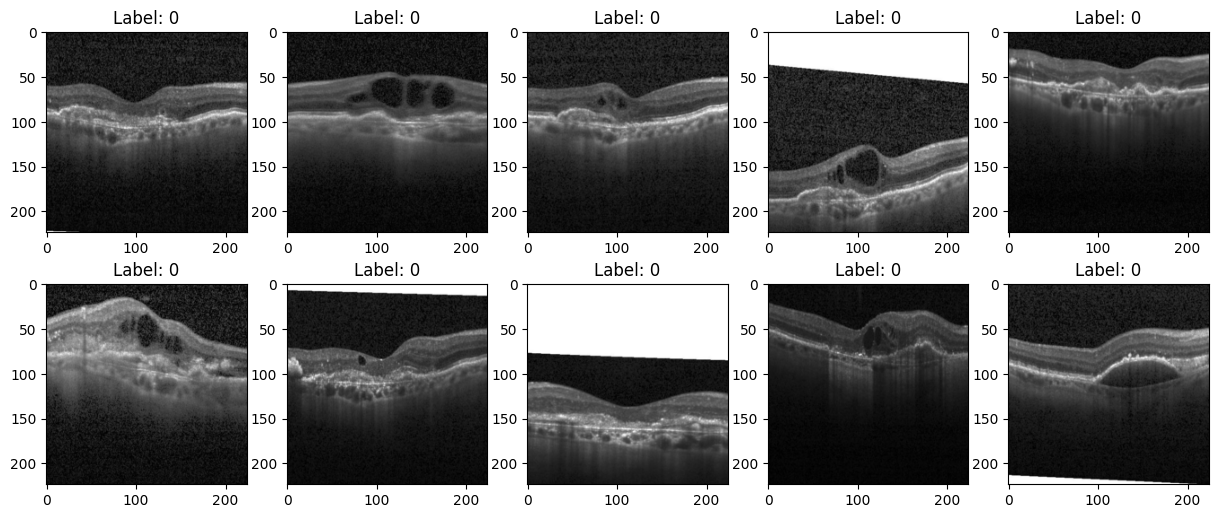

In [7]:
# display data without normalization
dataset = CustomImageSet(test_path, 10, simple_transform)
display_n_images(10, dataset)

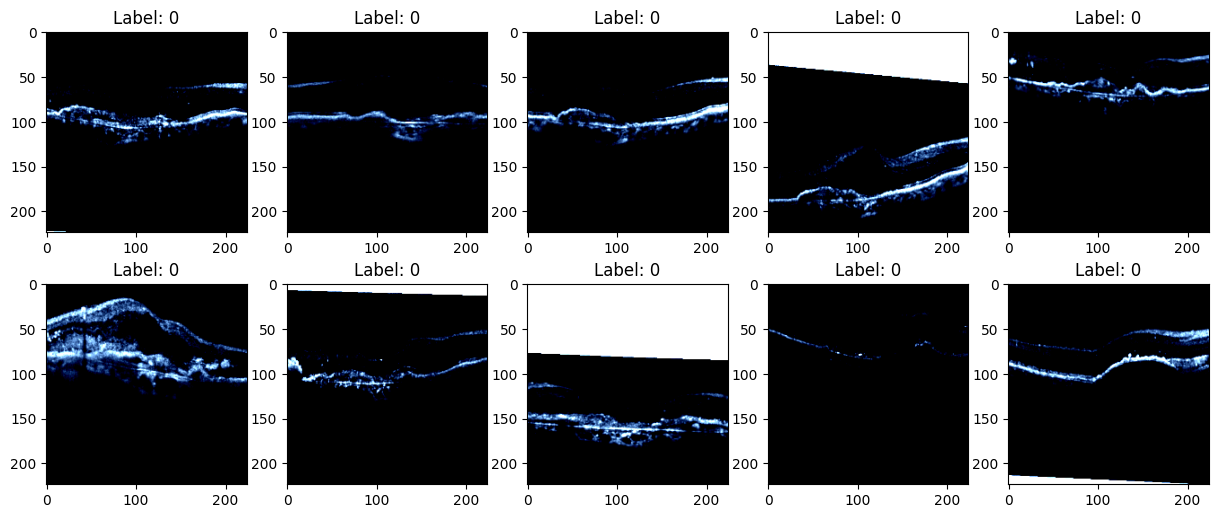

In [8]:
# display data after normalization
dataset = CustomImageSet(test_path, 10, resnet50_transforms)
display_n_images(10, dataset)

In [9]:
resnet50 = torchvision.models.resnet50(weights=weights).to(cuda)

In [10]:
def summary_of_model(model, input_size):
    print(summary(model=model,
                  input_size=input_size,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])
          )

In [11]:
summary_of_model(resnet50, (32, 3, 224, 224))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

C:\Users\voicu\PycharmProjects\license\venv\Lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


In [12]:
for param in resnet50.parameters():
    param.requires_grad = False

In [13]:
num_filters = resnet50.fc.in_features
# define a new layer
resnet50.fc = nn.Linear(num_filters, 4)

In [14]:
summary_of_model(resnet50, (32, 3, 224, 224))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [15]:
print('Images in train folder:')
count_images(train_path)

Images in train folder:
In CNV folder are 35753 images.
In DME folder are 9888 images.
In DRUSEN folder are 7153 images.
In NORMAL folder are 24856 images.


In [16]:
print('Images in validation folder:')
count_images(validation_path)

Images in validation folder:
In CNV folder are 850 images.
In DME folder are 850 images.
In DRUSEN folder are 850 images.
In NORMAL folder are 850 images.


In [17]:
print('Images in test folder:')
count_images(test_path)

Images in test folder:
In CNV folder are 850 images.
In DME folder are 850 images.
In DRUSEN folder are 850 images.
In NORMAL folder are 850 images.


In [18]:
data_transforms = {
    'train': data_augmentation_transforms,
    'val': data_augmentation_transforms,
    'test': data_augmentation_transforms
}

In [19]:
train_dataset = CustomImageSet(train_path, 10000, transform=data_transforms['train'])
validation_dataset = CustomImageSet(validation_path, transform=data_transforms['val'])

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(validation_dataset, shuffle=True)

In [21]:
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [22]:
data_sizes = {
    'train': len(train_dataset),
    'val': len(validation_dataset)
}

In [23]:
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
def train_model(model, number_of_epochs, loss_function, optimizer, scheduler):
    best_acc = 0.0

    for epoch in range(number_of_epochs):
        print(f'Epoch {epoch}:')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            loss = 0.0
            corrects = 0

            dataloader = dataloaders[phase]
            with tqdm(total=len(dataloader), desc=f'{phase} Epoch {epoch}', unit='batch') as pbar:
                for images, labels in dataloader:
                    images = images.to(cuda)
                    labels = labels.to(cuda)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        _, predictions = torch.max(outputs, 1)
                        loss = loss_function(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    loss += loss.item() * images.size(0)
                    corrects += torch.sum(predictions == labels.data)

                    pbar.update(1)

            if phase == 'train':
                scheduler.step()

            epoch_loss = loss / data_sizes[phase]
            epoch_acc = corrects.double() / data_sizes[phase]

            print(f'Epoch {epoch}: loss = {epoch_loss:.4f}, accuracy = {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

In [25]:
model = train_model(resnet50, 4, loss_function, optimizer, exp_lr_scheduler)

Epoch 0:


train Epoch 0: 100%|██████████| 1158/1158 [33:15<00:00,  1.72s/batch]


Epoch 0: loss = 0.0005, accuracy = 0.6352


val Epoch 0: 100%|██████████| 3400/3400 [01:20<00:00, 42.24batch/s]


Epoch 0: loss = 0.0008, accuracy = 0.6897
Epoch 1:


train Epoch 1: 100%|██████████| 1158/1158 [09:55<00:00,  1.94batch/s]


Epoch 1: loss = 0.0004, accuracy = 0.7160


val Epoch 1: 100%|██████████| 3400/3400 [01:21<00:00, 41.50batch/s]


Epoch 1: loss = 0.0002, accuracy = 0.7294
Epoch 2:


train Epoch 2: 100%|██████████| 1158/1158 [07:32<00:00,  2.56batch/s]


Epoch 2: loss = 0.0003, accuracy = 0.7366


val Epoch 2: 100%|██████████| 3400/3400 [01:22<00:00, 41.20batch/s]


Epoch 2: loss = 0.0003, accuracy = 0.7376
Epoch 3:


train Epoch 3: 100%|██████████| 1158/1158 [07:24<00:00,  2.60batch/s]


Epoch 3: loss = 0.0004, accuracy = 0.7480


val Epoch 3: 100%|██████████| 3400/3400 [01:24<00:00, 40.08batch/s]

Epoch 3: loss = 0.0005, accuracy = 0.7506


In [26]:
torch.save(resnet50.state_dict(), "models/resnet50.pth")

In [27]:
test_dataset = CustomImageSet(test_path, transform=data_transforms['test'])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [28]:
true_labels = []
predicted_labels = []

In [29]:
with torch.no_grad():
    loss = 0.0
    corrects = 0
    total_samples = 0

    for images, labels in test_dataloader:
        images = images.to(cuda)
        labels = labels.to(cuda)

        outputs = resnet50(images)
        _, predictions = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)

        loss += loss.item() * images.size(0)
        corrects += torch.sum(predictions == labels.data)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

test_accuracy = corrects / len(test_dataset)
test_loss = loss / len(test_dataset)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.7679
Test loss: 0.0021


In [30]:
classification_rep = classification_report(true_labels, predicted_labels)
print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       850
           1       0.81      0.77      0.79       850
           2       0.76      0.61      0.68       850
           3       0.76      0.88      0.81       850

    accuracy                           0.77      3400
   macro avg       0.77      0.77      0.76      3400
weighted avg       0.77      0.77      0.76      3400



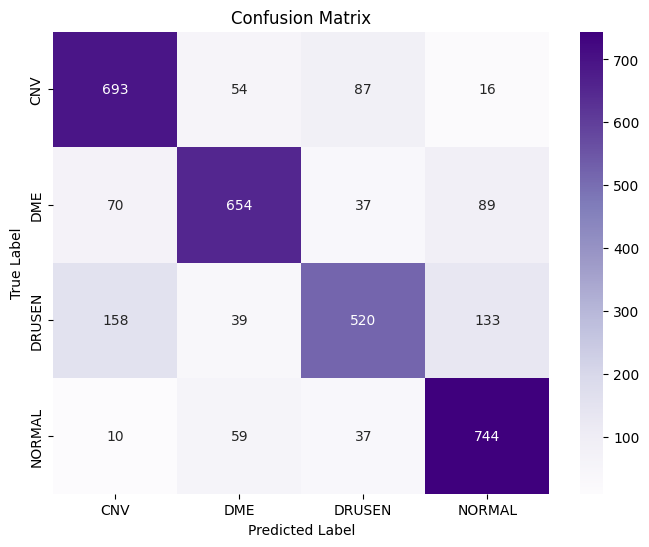

In [31]:
plot_confusion_matrix(true_labels, predicted_labels)

In [32]:
def flatten_model(model):
    layers = []
    for layer in model.children():
        if list(layer.children()):  # if the layer has children layers
            layers.extend(flatten_model(layer))
        else:
            layers.append(layer)
    return layers

In [33]:
all_layers = flatten_model(resnet50)
print("Number of layers in the base model:", len(all_layers))

Number of layers in the base model: 126


In [34]:
for param in resnet50.parameters():
    param.requires_grad = False

In [35]:
summary_of_model(resnet50, (32, 3, 224, 224))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 4]              --                   False
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    └─

In [36]:
for param in resnet50.layer4.parameters():
    param.requires_grad = True

In [37]:
for param in resnet50.fc.parameters():
    param.requires_grad = True

In [38]:
summary_of_model(resnet50, (32, 3, 224, 224))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [39]:
# define the optimizer with different learning rates
optimizer = torch.optim.SGD([
    {'params': resnet50.layer4.parameters(), 'lr': 0.0001},
    {'params': resnet50.fc.parameters(), 'lr': 0.001}
], momentum=0.9)

In [40]:
model = train_model(resnet50, 4, loss_function, optimizer, exp_lr_scheduler)

Epoch 0:


train Epoch 0: 100%|██████████| 1158/1158 [10:11<00:00,  1.89batch/s]


Epoch 0: loss = 0.0005, accuracy = 0.7839


val Epoch 0: 100%|██████████| 3400/3400 [01:21<00:00, 41.48batch/s]


Epoch 0: loss = 0.0000, accuracy = 0.8068
Epoch 1:


train Epoch 1: 100%|██████████| 1158/1158 [09:18<00:00,  2.07batch/s]


Epoch 1: loss = 0.0002, accuracy = 0.8282


val Epoch 1: 100%|██████████| 3400/3400 [01:22<00:00, 41.39batch/s]


Epoch 1: loss = 0.0002, accuracy = 0.8197
Epoch 2:


train Epoch 2: 100%|██████████| 1158/1158 [09:22<00:00,  2.06batch/s]


Epoch 2: loss = 0.0003, accuracy = 0.8484


val Epoch 2: 100%|██████████| 3400/3400 [01:27<00:00, 38.98batch/s]


Epoch 2: loss = 0.0000, accuracy = 0.8441
Epoch 3:


train Epoch 3: 100%|██████████| 1158/1158 [09:04<00:00,  2.13batch/s]


Epoch 3: loss = 0.0001, accuracy = 0.8610


val Epoch 3: 100%|██████████| 3400/3400 [01:21<00:00, 41.51batch/s]

Epoch 3: loss = 0.0002, accuracy = 0.8553


In [41]:
torch.save(resnet50.state_dict(), "models/resnet50_fine_tuning2.pth")

In [41]:
true_labels = []
predicted_labels = []

In [42]:
with torch.no_grad():
    loss = 0.0
    corrects = 0
    total_samples = 0

    for images, labels in test_dataloader:
        images = images.to(cuda)
        labels = labels.to(cuda)

        outputs = resnet50(images)
        _, predictions = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)

        loss += loss.item() * images.size(0)
        corrects += torch.sum(predictions == labels.data)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

test_accuracy = corrects / len(test_dataset)
test_loss = loss / len(test_dataset)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.8891
Test loss: 0.0010


In [43]:
classification_rep = classification_report(true_labels, predicted_labels)
print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       850
           1       0.92      0.92      0.92       850
           2       0.87      0.82      0.85       850
           3       0.87      0.96      0.91       850

    accuracy                           0.89      3400
   macro avg       0.89      0.89      0.89      3400
weighted avg       0.89      0.89      0.89      3400



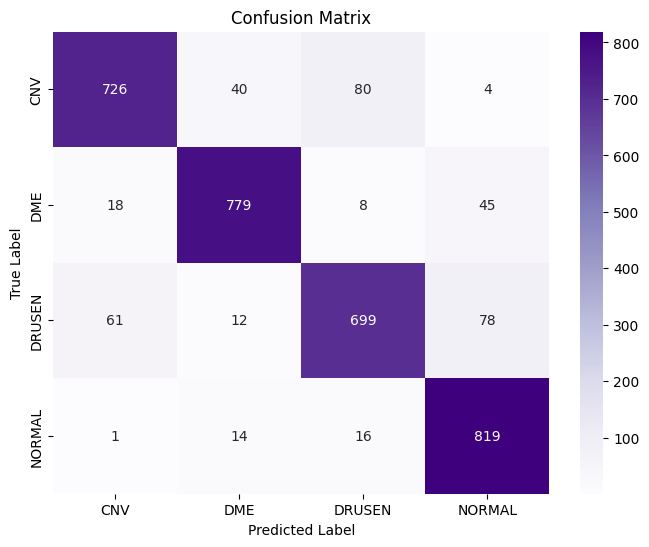

In [44]:
plot_confusion_matrix(true_labels, predicted_labels)

In [45]:
# optimizer with different learning rates
optimizer = torch.optim.Adam([
    {'params': resnet50.layer4.parameters(), 'lr': 1e-4},
    {'params': resnet50.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True)

C:\Users\voicu\PycharmProjects\license\venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [47]:
def train_model(model, number_of_epochs, loss_function, optimizer, scheduler):
    best_acc = 0.0

    for epoch in range(number_of_epochs):
        print(f'Epoch {epoch}:')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            corrects = 0

            dataloader = dataloaders[phase]
            with tqdm(total=len(dataloader), desc=f'{phase} Epoch {epoch}', unit='batch') as pbar:
                for images, labels in dataloader:
                    images = images.to(cuda)
                    labels = labels.to(cuda)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        _, predictions = torch.max(outputs, 1)
                        loss = loss_function(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * images.size(0)
                    corrects += torch.sum(predictions == labels.data).item()

                    pbar.update(1)

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = corrects / data_sizes[phase]

            print(f'{phase} Epoch {epoch}: loss = {epoch_loss:.4f}, accuracy = {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), 'models/best_resnet50.pth')

    return model

In [48]:
model = train_model(resnet50, 3, loss_function, optimizer, exp_lr_scheduler)

Epoch 0:


train Epoch 0: 100%|██████████| 1158/1158 [10:00<00:00,  1.93batch/s]


train Epoch 0: loss = 0.1979, accuracy = 0.9320


val Epoch 0: 100%|██████████| 3400/3400 [01:28<00:00, 38.35batch/s]


val Epoch 0: loss = 0.2365, accuracy = 0.9209
Epoch 1:


train Epoch 1: 100%|██████████| 1158/1158 [08:38<00:00,  2.23batch/s]


train Epoch 1: loss = 0.1745, accuracy = 0.9410


val Epoch 1: 100%|██████████| 3400/3400 [01:21<00:00, 41.86batch/s]


val Epoch 1: loss = 0.2189, accuracy = 0.9268
Epoch 2:


train Epoch 2: 100%|██████████| 1158/1158 [07:01<00:00,  2.74batch/s]


train Epoch 2: loss = 0.1559, accuracy = 0.9473


val Epoch 2: 100%|██████████| 3400/3400 [00:54<00:00, 62.16batch/s]

val Epoch 2: loss = 0.2210, accuracy = 0.9247


In [49]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    loss = 0.0
    corrects = 0
    total_samples = 0

    for images, labels in test_dataloader:
        images = images.to(cuda)
        labels = labels.to(cuda)

        outputs = resnet50(images)
        _, predictions = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)

        loss += loss.item() * images.size(0)
        corrects += torch.sum(predictions == labels.data)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

test_accuracy = corrects / len(test_dataset)
test_loss = loss / len(test_dataset)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.9441
Test loss: 0.0001


In [50]:
classification_rep = classification_report(true_labels, predicted_labels)
print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       850
           1       0.96      0.96      0.96       850
           2       0.92      0.93      0.93       850
           3       0.93      0.98      0.96       850

    accuracy                           0.94      3400
   macro avg       0.94      0.94      0.94      3400
weighted avg       0.94      0.94      0.94      3400



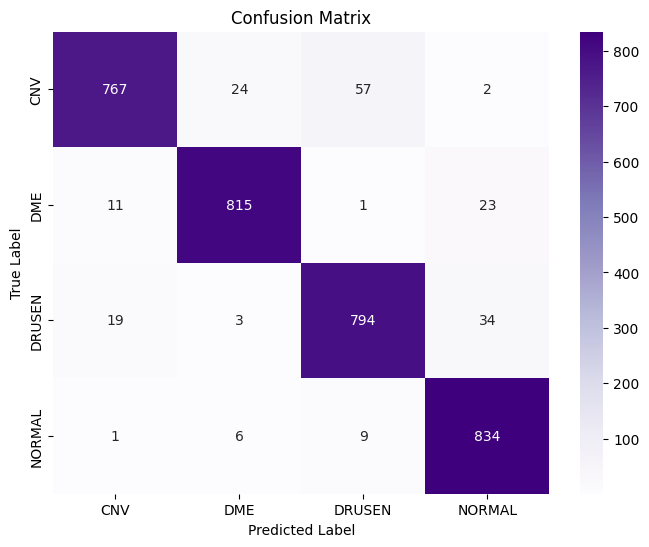

In [51]:
plot_confusion_matrix(true_labels, predicted_labels)

In [52]:
torch.save(resnet50.state_dict(), "models/resnet50_fine_tuning2.pth")